# Machine Learning Explainability with SHAP
    O objetivo desse estudo é utilizar SHAP para fazer uma análise de quais variáveis tiveram maior influência na probabilidade de sobrevivência ao naufrágio (desafio Titanic).

### Titanic: Machine Learning from Disaster

###### Historinha
    Clássico! Desafio alguém que não chorou assitindo ao filme, mas de raiva! Aquele pedaço de madeira dava p/ os dois! kkk
    Brincadeiras a parte...
    O naufrágio aconteceu em 15 de abril de 1912, morreram 1502 pessoas de um total de 2224 passageiros. Alguns grupos de pessoas eram mais propensos a escaparem da morte do que outros. Por exemplo, mulheres, crianças e passageiros da 1ª Classe. Então, acho que da pra encontrar algum padrão que podemos extrair dos dados.
    
###### OBS
    Lembrando que a ideia aqui é utilizar o método SHAP para explicabilidade do modelo!!! Por isso foco não é necessariamente ter a melhor acurácia de modelo, mas sim um valor suficiente para a garantia de que a explicabilidade possa ser confiável.

### ------------------------------------------------------------------------------------------------------------------------------------------------

###### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

#visualização
from plotly.offline import iplot
import plotly.graph_objects as go
import cufflinks as cf

#### Dataset

* PassengerId: Número de identificação do passageiro
* Survived: flag marcando se foi sobrevivente ou não --- **0 = No, 1 = Yes**
* Pclass: classe no navio --- **1 = 1st, 2 = 2nd, 3 = 3rd**
* Name: nome do passageiro
* Sex: gênero
* Age: idade em anos
* SibSp: quantidade de irmãos / cônjuges a bordo do Titanic
* Parch: quanitdade de pais / filhos a bordo do Titanic
* Ticket: Número do ticket
* Fare: Tarifa do passageiro
* Cabin: Número da cabine
* Embarked: porto de embarcação ---  **C = Cherbourg, Q = Queenstown, S = Southampton**

Notas:

sibsp: O conjunto de dados define as relações familiares desta forma ...
  
      Irmão = irmão, irmã, meio-irmão, meia-irmã
      Cônjuge = marido, esposa (amantes e noivos foram ignorados)

parch: O conjunto de dados define as relações familiares desta forma ...
   
       Pai = mãe, pai
       Criança = filha, filho, enteada, enteado
       Algumas crianças viajavam apenas com a babá, portanto parch = 0 para elas.

### ------------------------------------------------------------------------------------------------------------------------------------------------

# Etapas
1. Qual o problema?
2. Carregando os dados
3. Análise Exploratória
4. Tratamento dos dados
5. Modelagem e Avaliação
6. **(e foco desse notebook) SHAP Explainability**

### ------------------------------------------------------------------------------------------------------------------------------------------------

## 1. Qual o problema?
   **Desafio:** O objetivo do desafio é utilizar os dados disponíveis para medir a probabilidade de sobrevivência dos passageiros do Titanic.
    
   **SHAP:** O objetivo desse estudo é utilizar SHAP para fazer uma análise de quais variáveis tiveram maior influência na probabilidade de sobrevivência.

### ------------------------------------------------------------------------------------------------------------------------------------------------

## 2.Carregando os Dados

###### Carregando base

In [2]:
train = pd.read_csv('titanic data/train.csv')
test = pd.read_csv('titanic data/test.csv')

print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (891, 12)
test shape:  (418, 11)


### ------------------------------------------------------------------------------------------------------------------------------------------------

## 3. Análise Exploratória

In [3]:
print('Shape:', train.shape)
train.head(2)

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


##### Tipo dos dados

In [4]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

##### Checando nulos

In [5]:
print('Dados faltantes:')
train.isnull().sum()

Dados faltantes:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

###  Temos 3 features com dados faltantes. Cabin (maior número), Age e Embarked.
       Cabin: 77% faltante
       Age: 20% faltante
       Embarked: 0.22%

#####  Distribuição estatística

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
#Describe para categóricas
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"McCarthy, Mr. Timothy J",male,347082,G6,S
freq,1,577,7,4,644


#####  Visualizando Histogramas

In [9]:
cols_to_hist = ['Survived', 'Age', 'Pclass','Sex', 'SibSp','Parch', 'Embarked']
for col in cols_to_hist:
    train[col].iplot(kind='hist',
         title='Histograma '+ col)

######  Comentários
**Histograma Survived:** Morreram mais pessoas do que sobreviveram. 

             62% Morreram, enquanto 38% sobreviveram (lembrando que aqui é só o dataframe de treino). 

**Histograma Age:** vemos uma concentração de idade entre 18 e 38 anos
    
**Histograma Pclass:** mais pessoas na classe 3
  
**Histograma Sex:** mais homem (577 - 65% da base de treino)
  
**Histograma SibSp:** maior parte da base (68%) não tem irmãos/cônjuges a bordo. 23% tem apenas 1.
  
**Histograma Parch:** maior parte da base (76%) não tem pais/filhos a bordo. 13% tem apenas 1.
  
**Histograma Embarked:**  maior parte dos passageiros (72%) embarcaram Southampton

###  Visualizando histogramas considerando se sobreviveu ou não, para entendermos se classe, sexo, etc..podem ter influenciado na probabilidade de sobreviver ou não

#####  IDADE

In [10]:
train.query('Survived == 0')['Age'].iplot(kind='hist', title='Histograma Idade Não Sobreviventes', bins = 50)
train.query('Survived == 1')['Age'].iplot(kind='hist', title='Histograma Idade Sobreviventes', bins = 50)

######  Comentário
    Analisando a idade, é possível obervar que no histograma de sobreviventes, temos um "pico" no início do gráfico. O que indica uma hipótese de que crianças teriam mais chance de sobrevivencia.

#####  SEXO

In [11]:
train.query('Survived == 0')['Sex'].iplot(kind='hist', title='Histograma Gênero Não Sobreviventes', bins = 50)
train.query('Survived == 1')['Sex'].iplot(kind='hist', title='Histograma Gênero Sobreviventes', bins = 50)

######  Comentário
    É possível observar que os gráficos se "invertem". Quando olhamos para os passageiros que NÃO sobreviveram, a maioria é homem. Já quando olhamos para os passageiros do grupo que sobreviveram, temos mais mulheres. 233 mulheres sobreviveram, e apenas 109 homens. O que indicada que a hipótese de que as mulheres tinham mais chance de sobrevivência está correta.

######  Até aqui se confirma a frase tão falada no filme "Crianças e Mulheres primeiro" (para os botes salva vidas)

#####  CLASSE

In [12]:
train.query('Survived == 0')['Pclass'].value_counts().iplot(kind='bar', title='Histograma Classe de Não Sobreviventes', bins = 50)
train.query('Survived == 1')['Pclass'].value_counts().iplot(kind='bar', title='Histograma Classe da Passagem de Sobreviventes', bins = 50)

######  Comentário
    No grupo de NÃO sobreviventes se destaca a classe 3. Já no grupo de sobreviventes observamos que o classe 1 predomina. Hipotese já imaginada, pobre tem mais chance de morrer que rico :(

## 4. Tratamento dos dados

In [13]:
df_train = train
df_test = test

#### Tratando nulos das colunas Cabin (maior número), Age e Embarked. (já vistos anteriormente no código)
       Age: 20% faltante
       Embarked: 0.22%
       
       Idade vou colocar o valor da mediana.
       Embarque vou colocar o valor com maior frequência, que é S
       
       Na base de teste tem um da faltante na coluna Fare, vou substituir pela média

In [14]:
data = [df_train, df_test]
for dataset in data:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['Embarked'].fillna('S', inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)

print('nulls train:',df_train.isnull().sum())
print('\nnulls test:',df_test.isnull().sum())

nulls train: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

nulls test: PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


#### Convertendo Sex em 0 e 1

In [15]:
data = [df_train, df_test]
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})

#### Convertendo Embarked em 0, 1 e 2

In [16]:
list_cols_dummies = ['Embarked']
for coluna in list_cols_dummies:
    #Treino
    coluna_dummies = pd.get_dummies(df_train[coluna], drop_first=False, prefix=coluna)
    df_train = pd.concat([coluna_dummies, df_train.loc[:,list(df_train.columns)]], axis=1)
    df_train = df_train.drop([coluna], axis=1)
    #Test
    coluna_dummies = pd.get_dummies(df_test[coluna], drop_first=False, prefix=coluna)
    df_test = pd.concat([coluna_dummies, df_test.loc[:,list(df_test.columns)]], axis=1)
    df_test = df_test.drop([coluna], axis=1)

#### Float to int

In [17]:
print('ANTES df_train:\n', df_train.dtypes)
print('ANTES df_test:\n', df_test.dtypes)

# Colunas tipo float
float_cols = df_train.dtypes==float
float_cols = df_train.columns[float_cols].tolist()

for coluna in float_cols:
    df_train[coluna] = df_train.apply(lambda x: int(round(x[coluna])), axis=1)
    df_test[coluna] = df_test.apply(lambda x: int(round(x[coluna])), axis=1)
print('\n \n DEPOIS df_train:\n', df_train.dtypes)
print('\n \n DEPOIS df_test:\n', df_test.dtypes)

ANTES df_train:
 Embarked_C       uint8
Embarked_Q       uint8
Embarked_S       uint8
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
dtype: object
ANTES df_test:
 Embarked_C       uint8
Embarked_Q       uint8
Embarked_S       uint8
PassengerId      int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
dtype: object

 
 DEPOIS df_train:
 Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
PassengerId     int64
Survived        int64
Pclass          int64
Name           object
Sex             int64
Age             int64
SibSp           int64
Parch           int64
Ticket         object
Fare            int64
Cabin     

#### Correlação

<AxesSubplot:>

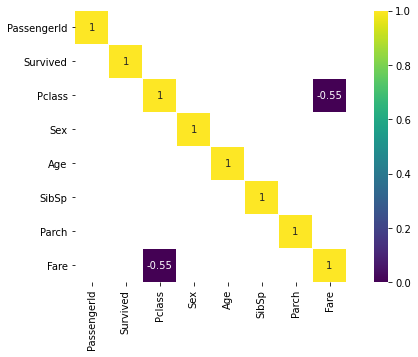

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

#Cortando variáveis altamente correlacionadas => Correlação acima de 0.7 sai
f, ax = plt.subplots(figsize=(10, 5))

corr = train.corr()
corr = corr[(corr>=0.7) | (corr <= -0.4)]

sns.heatmap(corr,
            cmap='viridis',
            linewidths = 0.1,
            vmax=1.0, vmin= 0,
           annot = True, annot_kws={'size': 10}, square = True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## 5. Modelagem e Avaliação

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, mean_squared_error, f1_score

#### Desconsiderando algumas variáveis
    Obs: Cabin poderia ter uma análise mais detalhada, as letras tem uma ordem dentro do navio. Mas vou deixar pra um outro momento. Lembrando que o intuito aqui é o entendimento do SHAP.

#### Separando em treino e teste

In [20]:
X_train = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis=1)
y_train = df_train['Survived']
X_test  = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

#### Fit e score

In [21]:
model = RandomForestClassifier(random_state=0)

# Estimando o modelo com a base de treino
model.fit(X_train, y_train)

# verificar a acurácia do modelo
acuracia = round(model.score(X_train, y_train) * 100, 2)
print('Acurácia com RandomForestClassifier:', acuracia, '%')

Acurácia com RandomForestClassifier: 96.52 %


### Vou utilizar o K-fold para uma classificação mais confiável e realista   

#### K-Fold Cross Validation

    K-Fold Cross Validation divide aleatoriamente os dados de treinamento em K subsets chamados folds. Se o k = 3, por exemplo, nosso modelo Random Forest seria treinado e avaliado 5 vezes.
    Por exemplo, em uma etapa o modelo seria treinado com o subconjunto 1 e 2 e avaliado com o subconjunto 3. Em uma segunda etapa treinado com o subconjunto 1 e 3, e avaliado com o 2. E uma terceira etapa treinado com o 2 e 3 e avaliado com o 1.
    O resultado neste caso seria uma matriz com 3 "notas" diferentes. Aí podemos calcular a média e o desvio padrão delas, por exemplo.

#### Teste com K = 10

In [22]:
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(n_estimators=100)

scores = cross_val_score(model, X_train, y_train, cv=10, scoring = 'accuracy')

print('Score:', scores)
print('\nMédia:', round(scores.mean(),2) * 100 , '%')
print('\nDesvio Padrão:', round(scores.std(),2) * 100 , '%')

Score: [0.73333333 0.79775281 0.7752809  0.82022472 0.88764045 0.82022472
 0.86516854 0.76404494 0.82022472 0.84269663]

Média: 81.0 %

Desvio Padrão: 4.0 %


In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

predictions = cross_val_predict(model, X_train, y_train, cv=3)

print('Precision:', precision_score(y_train, predictions))
print('Recall:',recall_score(y_train, predictions))
print('F1:',f1_score(y_train, predictions))

confusion_matrix(y_train, predictions)

Precision: 0.7439759036144579
Recall: 0.7222222222222222
F1: 0.7329376854599406


array([[464,  85],
       [ 95, 247]], dtype=int64)

### Bom, a partir daqui poderia fazer ajuste dos hiperparâmetros buscando melhorar a performance do modelo. MAS, como mencionado várias vezes, a ideia aqui é utilizar o método SHAP. Como a acurácia obtida já está 'boa', podemos confiar na explicabilidade das variáveis. Então, a partir daqui não me importarei mais com as métricas e partirei para a análise com SHAP

In [24]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [25]:
submission = pd.DataFrame({
        'PassengerId': df_test['PassengerId'],
        'Survived': pred
    })
submission.to_csv('submission.csv', index=False)

### Essa submissão gerou um score de 75% no kaggle

### ------------------------------------------------------------------------------------------------------------------------------------------------

### ------------------------------------------------------------------------------------------------------------------------------------------------

# 6. SHAP Explainability

### Funções

In [26]:
def create_shap_dataframe(model_explainer, df, classe):
    # Cria um dataframe com os valores shap para o conjunto de treinamento.
    df_shap_values = pd.DataFrame(model_explainer.shap_values(df)[classe])
    # Ajusta o nome das colunas.
    df_shap_values.columns = df.columns
    # Ajusta o índice do DataFrame.
    df_shap_values.index = df.index
    return df_shap_values

def calculate_shap_importances(df_shap):
    """ Calcula a média de importâncias para cada variável. """
    # Calcula a média dos valores absolutos para cada exemplo.
    shap_importances = df_shap.abs().mean().sort_values(ascending=False)
    # Divide a importância das variáveis pela soma, representando percentuais.
    shap_importances = shap_importances / shap_importances.sum() * 100
    return shap_importances

def summary_plot_Function(df_shap_values, df, title):
    import shap
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 5))
    shap.summary_plot(df_shap_values.values, df, show=False)
    plt.grid()
    plt.title(title)
    plt.xlabel('Valor SHAP')
    plt.ylabel('Atributo')
    plt.plot()
    
def barplot_importances(shap_importances, title):
    import seaborn as sns
    """ Plota um barplot de importâncias dos modelos. """
    shap_importances = shap_importances.reset_index()
    shap_importances.columns = ['Atributo', 'Importância (%)']
    sns.barplot(y='Atributo', 
                x='Importância (%)', 
                data=shap_importances, 
                orient='h')
    plt.title(title)
    plt.grid()
    plt.show()
    
def ABS_SHAP(df_shap, df, df_len):
    import matplotlib.pyplot as plt
    import numpy as np
    np.seterr(divide='ignore', invalid='ignore')
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index(drop=True)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
#     corr_df['Sign'] = np.where(corr_df['Corr']>0,"#1E88E5", "#FF0D57")
    corr_df['Sign'] = np.where(corr_df['Corr']>0,"#FF0D57", "#1E88E5")
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2.tail(df_len).copy()
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6), legend=True, label="Positive Impact" )
    ax.set_ylabel("")
    ax.set_xlabel("SHAP Value (impact on model output)", fontsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    
    ax.plot([1], color="#1E88E5", linewidth=8, label="Negative Impact")
    
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles[::-1], labels[::-1], numpoints=10, loc='lower right', borderaxespad=1, fontsize=12)

    plt.title('Simplified Feature Importance', fontdict={'fontsize': 21})
    plt.show()

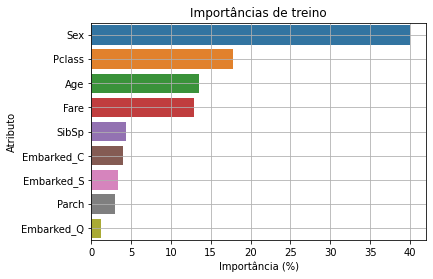

In [27]:
model_explainer = shap.TreeExplainer(model)
#------------------------------------------------------------------------------------------------------
# Cria o DataFrame com valores shap
X_train_shap_values = create_shap_dataframe(model_explainer, X_train, classe=1)
X_test_shap_values = create_shap_dataframe(model_explainer, X_test, classe=1)
#------------------------------------------------------------------------------------------------------
train_shap_importances = calculate_shap_importances(X_train_shap_values)
barplot_importances(train_shap_importances, 'Importâncias de treino')

## Comentários da visualização acima
        fica claro a importância da variável 'Sex' no modelo. Seguido da variável classe e da idade. O que nos lembra das hipóteses levantadas. 
        Mulheres e crianças sobreviveram mais?
        Classes mais baixas morreram mais?

### SUMMARY PLOT

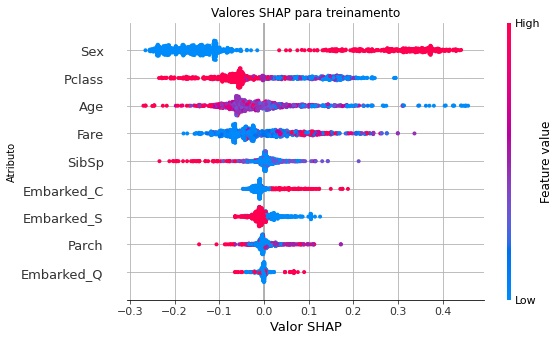

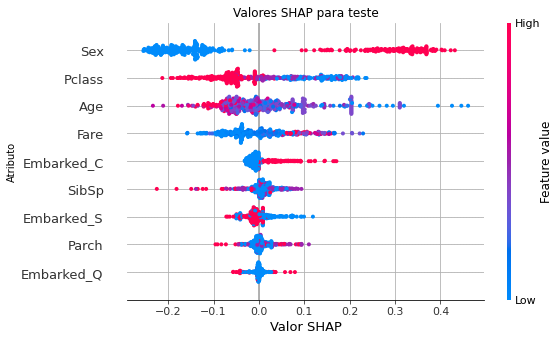

In [28]:
#------------------------------------------------------------------------------------------------------
summary_plot_Function(X_train_shap_values, X_train, title='Valores SHAP para treinamento')
summary_plot_Function(X_test_shap_values, X_test, title='Valores SHAP para teste')

## Comentários da visualização acima
   **Como ler esse tipo de gráfico:**
        Cada pontinho dess é uma amostra classificada. Eixo 'x' dessa visualização é o Valor SHAP, que está relacionado com o valor de saída do modelo. Então quanto mais pra direita do eixo x (valor SHAP), maior a chance do passageiro ser classificado como sobrevivente (1), quanto mais pra esquerda, maior a chance do passageiro ser classificado como NÃO sobrevivente (0).
            Lembrando: 0: não sobrevivendo --- 1:sobrevivente
        
        SEX
        Lembra que '0' é homem e '1' é mulher? 
        Então, podemos ver que quanto maior o valor da feature, mais vermelho é. Pensando na variável 'Sex', se for vermelho é 1 (mulher), azul é 0 (homem)
        Fica clara essa separação nessa visualização. Quanto mais vermelho (mulher), mais o gráfico tende para a direita do eixo 'x' (valor SHAP). Ou seja, quanto mais vermelho (mulher), mais chances de sobreviver (direita do eixo x).
        
        CLASSE
        Lembra que comentei a hipotese de que pobre morreu mais?
        Então, pensando na variável 'Pclass', quanto mais vermelho, maior a classe (mais pobre kkk). E quanto mais azul, menor a classe (first class, mais rico).
        A leitura é: Quanto mais vermelho, mais as predições estão pro lado esquerdo do gráfico (mais chances de não sobreviver). Ou seja quanto mais vermelho, maior a classe (mais pobre), mais pro lado esquerdo do gráfico, menos chances de sobreviver (ser classificado como Survived = 0)
        
        IDADE
        Lembra que comentei da hipotese que crianças mais novas teriam mais chances de sobrevivier?
        Então, podemos ver que quanto menor a idade (mais azul), mais pro lado direito do gráfico está (mais chances de ser classificado como sobrevivente)
        
        FARE
        Caracterítica que anda junto com classe no navio. Quanto mais caro o bilhete, melhor a classe.
        E a gente consegue ver que as bolinhas azuis pra variável 'Fare' (valor de bilhete mais barato) estão do lado esquerdo do gráfico, ou seja, tem mais probabilidade de serem classificados como não sobreviventes.

### Simplified plot

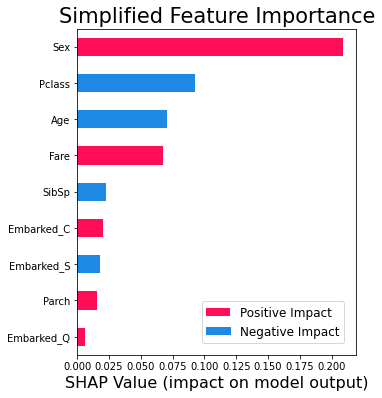

In [29]:
#------------------------------------------------------------------------------------------------------
ABS_SHAP(X_train_shap_values, X_train, 20)
#------------------------------------------------------------------------------------------------------

## Comentários da visualização acima
   **Como ler esse tipo de gráfico:**
    Visualização que resume a anterior. Vermelho tem impacto positivo, ou seja, quanto maior, mais influencia para a classificação ser 1 (sobrevivente). Azul tem impacto negativo, ou seja, inverso, quanto maior, mais influencia para a classificação ser 0 (não sobrevivente)
    
    Ex:
    SEX ta como vermelho, então de uma forma geral, quanto maior a variável 'Sex' (mulher), maior a chance de sobreviver (classe 1)
    PCLASS ta como azul, então de uma forma geral, quanto menor a variávle 'Pclass' (mais perto da primeira classe, público rico), maior a chance de sobreviver (classe 1)

### Passageiros específicos
#### Observando com outro tipo de visualização. Agora pegando casos isolados

In [30]:
num_casos = 2

X_train_explainer = X_train.tail(num_casos).copy()
X_train_shap_values_explainer = X_train_shap_values.tail(num_casos).copy()
#------------------------------------------------------------------------------------------------------
#É necessário iniciar para visualizar
shap.initjs()

for i, v in enumerate(X_train_explainer.index):
    house_name = "Line "+str(v)
    print(house_name)
    #shap.force_plot(explainer.expected_value[0], shap_values[0])
    display(shap.force_plot(model_explainer.expected_value[0], X_train_shap_values_explainer.loc[[v]].values[0], X_train_explainer.loc[[v]]))
    #------------------------------------------------------------------------------------------------------

Line 889


Line 890


## Comentário da visualização acima
**Como ler esse tipo de gráfico:** Nesse tipo de gráfico podemos analisar casos individualmente, para uma amostra (passageiro) específico. Tamanho da barrinha de cada variável define o impacto dela no modelo, quanto maior, mais impacto. A cor define se impactou positivamente (vermelho) "empurrando pra direita" ou negativamente (azul) "empurrando pra esquerda". No gráfico, quanto mais o valor for "empurrado" para a direita, mais probabilidade de ser classificado como 1 (sobrevivente), quanto mais o valor for "puxado" pra esquerda, maior a probailidade de ser classificado como 0 (não sobrevivente).
        
   **Análise para o passageiro da linha 889**
            Podemos ver que as informações que mais tiveram peso para a classificação foram "Fare", seguido "Pclass" e "Age", todas na cor vermelha, ou seja, essas variáveis influenciaram na probabilidade do passageiro ser classificado como 1 (sobrevivente). E a única variável que "puxou" o valor para esquerda foi 'Sex', o fato de o passageiro ser homem. Neste caso, "apesar" dele ser homem, foi classificado como sobrevivente, porque o fato de ser novo (26 anos), ter pago 30 de taria para estar na classe 1 (first class :)) fez ele ser "sortudo" e ser classificado como sobrevivente. Rico tem sorte mesmo, né?
    
   **Análise para o passageiro da linha 890**
            Neste exemplo temos uma classificação 0 (não sobrevivente). A variável de maior peso foi "Sex", seguido de 'Embarked_Q" e "Pclass". O fato de ser homem, tem embarcado no porto "Q" e estar na classe 3, contribuiu para a classificação como 0 (não sobrevivente). A variável que "puxou para direita (para ser classificado como sobrevivente) foi "Age", mas apesar dele ter 32 anos, os outros fatores impactaram mais.
        
        

In [31]:
#train.iloc[889]
#train.iloc[890]

### Decision Plot
#### Observando com outro tipo de visualização. Ainda pegando casos isolados, aqui continuando com o passageiro da linhas 889

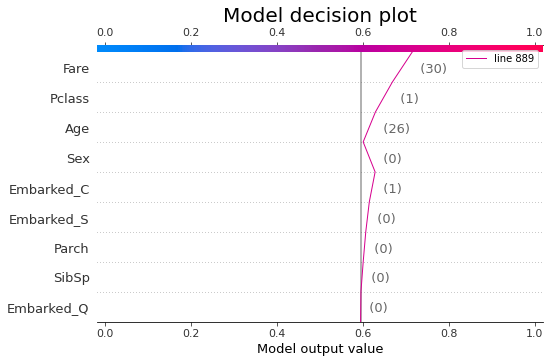

In [32]:
# Decision plot
shap.decision_plot(model_explainer.expected_value[1], X_train_shap_values_explainer.values[0], X_train_explainer,
                   legend_labels=["line " + str(x) for x in X_train_explainer.index],
                   show=False,
                   link='logit',
#                    highlight=0
                    feature_display_range=slice(None, -21, -1),
#                    plot_color=shap.plots.colors.red_blue.reversed()
                  )

plt.title("Model decision plot", fontdict={'fontsize': 20})
plt.show()

## Comentário da visualização acima
**Como ler esse tipo de gráfico:** Nesse tipo de gráfico podemos analisar casos individualmente, para uma amostra (passageiro) específico. Nele conseguimos ver o impacto de cada variável na classificação, a reta vai sendo "puxada" para a direito ou para a esquerda, conforme o valor da variável, até chegar na classificação. Quanto mais o valor for "puxado" para a direita, mais probabilidade de ser classificado como 1 (sobrevivente), quanto mais o valor for "puxado" pra esquerda, maior a probailidade de ser classificado como 0 (não sobrevivente).
        
   **Análise para o passageiro da linha 889**
            Podemos ver que as informações da parte inferior da visualização, "Embarked_Q", "Embarked_S", "SibSp" e "Parch" não influenciaram muito, a reta permaneceu perto do eixo central. Quando seguimos a reta e chegamos nas variáveis "Embarked_C" = 1 e "Age" = 26, podemos observar uma leve "puxada" para o lado direito do gráfico (probabilidade de ser classificado como sobrevivente), mas seguindo para a próxima variável, "sex" = 0 (homem), faz a reta ser puxada para a esquerda da visualização (probabilidade de ser classificado como não sobrevivente). Após isso, "Pclass" = 1 (first class) e "Fare" = 30 (valor maior que a maioria dos passageiros pagaram (veja a distriuição no plot abaixo), puxaram a reta mais ainda para a direita, o e o passageiro teve classificação 1 (sobrevivente).

**Distribuição da variável "Fare"**


In [37]:
train['Fare'].iplot(kind='hist', title='Histograma Fare Não Sobreviventes', bins = 200)

### Essa é mais uma visualização legal do SHAP
    É uma visualização iterativa, podemos escolher qual variável vai estar em cada eixo e analisarmos a correlação entre elas. f(x) é a probabilidade.


In [34]:
shap_values = model_explainer.shap_values(X_train)
shap.force_plot(model_explainer.expected_value[1], shap_values[1], X_train)

### Dependense plot
    Aqui cruzamos as variáveis entre elas, p/ tentar ver como elas se correlacionam entre si.


C:\ProgramData\Anaconda3\lib\site-packages\shap\plots\_scatter.py:639: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



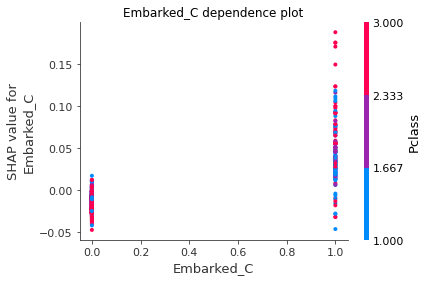

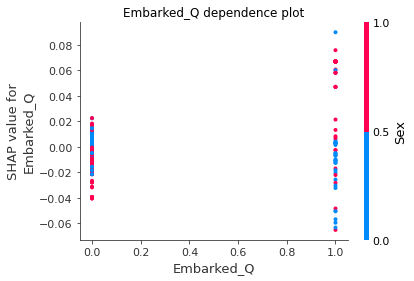

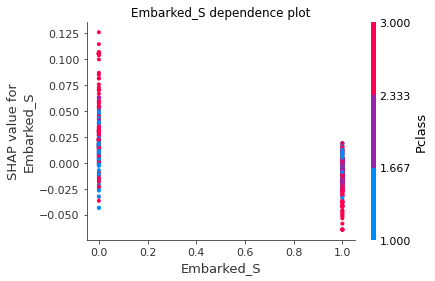

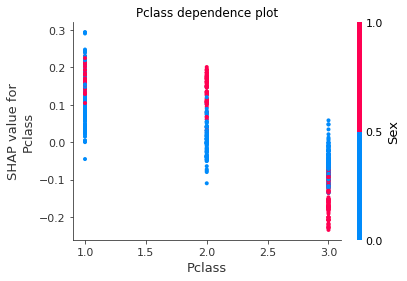

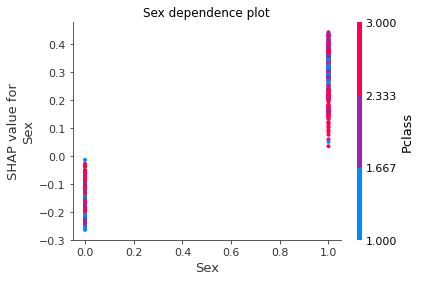

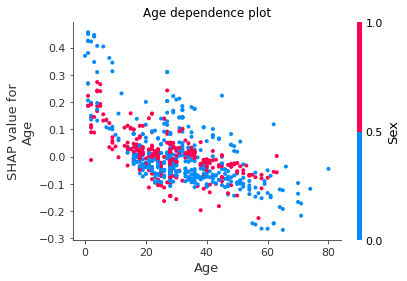

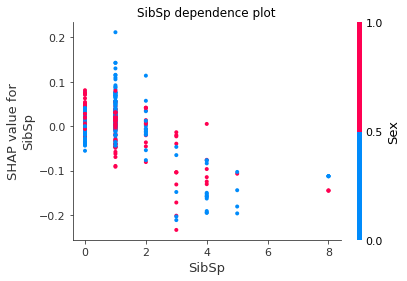

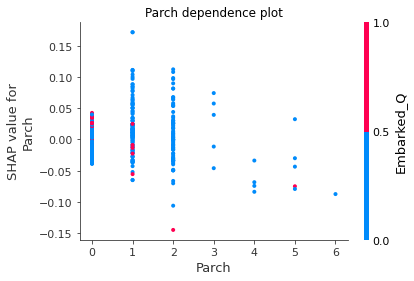

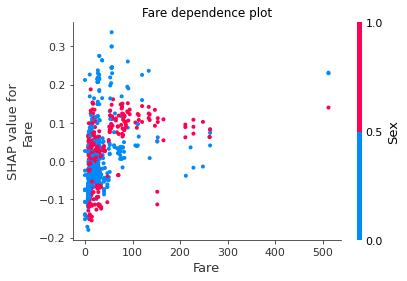

In [35]:
#dependence plot
def dependence_plot(column, df_shap_values, df, interaction='auto'):
    # interaction can be auto, columns_name or None
    
    fig, ax = plt.subplots()
    shap.dependence_plot(column, df_shap_values.values, df, interaction_index=interaction, show=False, ax=ax)
    plt.title(column+" dependence plot")
    plt.show()

for it, col in enumerate(X_train.columns):
    dependence_plot(col, X_train_shap_values, X_train)
    

### Guardando Valores das variáveis lado a lado com valor SHAP


In [36]:
indice = 1
a = X_train.loc[X_train.index == indice].T.rename(columns={indice:'Valores'})
b = X_train_shap_values.loc[X_train_shap_values.index == indice].T.rename(columns={indice:'SHAP Value'})
table = pd.merge(left = a,
                right = b,
                how='left',
                suffixes=('_t1', '_t2'),
                left_index=True,
                right_index=True)

table.sort_values(by ='SHAP Value', ascending = False)

,Valores,SHAP Value
Sex,1,0.281143
Pclass,1,0.159656
Fare,71,0.118870
Embarked_C,1,0.045342
SibSp,1,0.018683
Embarked_S,0,0.015557
Parch,0,0.000355
Embarked_Q,0,-0.002142
Age,38,-0.031179


# ---